In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.4 MB/s 
     |████████████████████████████████| 596 kB 49.6 MB/s 
     |████████████████████████████████| 6.6 MB 37.1 MB/s 
     |████████████████████████████████| 101 kB 11.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from ast import literal_eval
from scipy.fftpack import dct
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.fftpack import idct
from sklearn import preprocessing
import transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%matplotlib notebook

## 导入数据

In [ ]:
df  = pd.read_csv("/content/drive/MyDrive/情感打分数据包/中文/7月26日demo两条.csv")
df

,txt,year,text_length,txt_seg,Topic,Doc_ID,Score,label,negative_score,positicve_score,positicve_score__mean,negative_score_mean
0,坚持罢工争取增资【新华社陕北十八日电】东京消息：日本海员工人继续大罢工。全日海员工会，在与政...,1948.12.20,470,坚持 罢工 争取 增资 新华社 陕北 十八日 电 东京 消息 日本海 员工 人 继续 大 罢...,299,80956,"[-0.17992433482732492, -0.1460053249588042, -0...",6,"[0.7293623, 0.08481447]","[0.27063772, 0.9151855]",0.592912,0.407088
1,和平集会在纪念馆和平广场举行。侵华日军南京大屠杀遇难同胞纪念馆馆长朱成山表示，在这个具有纪念...,2012.08.16,686,和平 集会 在 纪念馆 和平 广场 举行 侵华日军南京大屠杀遇难同胞纪念馆 馆长 朱 成山 ...,228,38843,"[0.015359698043600992, 0.03786564722019095, 0....",6,"[0.49792624, 0.81404465]","[0.50207376, 0.18595535]",0.344015,0.655985


## 进行模型打分（情感分，分段），检查模型

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer
import torch 

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [ ]:
# 加载 BertForSequenceClassification, 预训练 BERT 模型 + 顶层的线性分类层 
model = BertForSequenceClassification.from_pretrained(
#     "model/bert-base-chinese-FineTuned-Binary-Best", # 小写的 12 层预训练模型
    "/content/drive/MyDrive/train（result_6）", # 小写的 12 层预训练模型
    num_labels = 2, # 分类数 --2 表示二分类
                    # 你可以改变这个数字，用于多分类任务  
#     output_attentions = False, # 模型是否返回 attentions weights.
#     output_hidden_states = False, # 模型是否返回所有隐层状态.
)
model.to(device)
model.eval()
model.zero_grad()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/train（result_6）')

In [ ]:
import torch.nn.functional as F
def split_chunk(text): #为什么要split_chunk, 512的数值有意义吗
    str = text
#     str = re.sub(r"\s+", "", str)
    str = str.strip()
    n = 512
    chunks = []
    i = 0
    while i < len(str):
        if i+n < len(str):
            chunks.append(str[i:i+n])
        else:
            chunks.append(str[i:len(str)])
        i += n
    return(chunks)


def getlb(txt):
    chunk_sample=split_chunk(txt)
    res = []
    for i in range(len(chunk_sample)):
        inp = tokenizer(chunk_sample[i], return_tensors='pt', padding="max_length", max_length=512)
        output = model(**inp)
        # output
        # output = F.softmax(output.pooler_output[0])
        embeding = output.logits.detach().numpy()
        lb = np.argmax(embeding)
        res.append(lb)
    return res

In [ ]:
df.iloc[0,1], getlb(df.iloc[0,1])

('1948.12.20', [1])

In [ ]:
df['sentiment_label'] = df.txt_seg.apply(getlb)
df

,txt,year,text_length,txt_seg,Topic,Doc_ID,Score,label,negative_score,positicve_score,positicve_score__mean,negative_score_mean,sentiment_label
0,坚持罢工争取增资【新华社陕北十八日电】东京消息：日本海员工人继续大罢工。全日海员工会，在与政...,1948.12.20,470,坚持 罢工 争取 增资 新华社 陕北 十八日 电 东京 消息 日本海 员工 人 继续 大 罢...,299,80956,"[-0.17992433482732492, -0.1460053249588042, -0...",6,"[0.7293623, 0.08481447]","[0.27063772, 0.9151855]",0.592912,0.407088,"[0, 1]"
1,和平集会在纪念馆和平广场举行。侵华日军南京大屠杀遇难同胞纪念馆馆长朱成山表示，在这个具有纪念...,2012.08.16,686,和平 集会 在 纪念馆 和平 广场 举行 侵华日军南京大屠杀遇难同胞纪念馆 馆长 朱 成山 ...,228,38843,"[0.015359698043600992, 0.03786564722019095, 0....",6,"[0.49792624, 0.81404465]","[0.50207376, 0.18595535]",0.344015,0.655985,"[0, 0]"


In [ ]:
df.to_excel("data_al/0520/0520_al.xlsx")

## 轨道check

In [ ]:
def standalize1(data):
    mu=np.mean(data,axis=0)
    sigma=np.std(data,axis=0)
    return (data-mu)/sigma

def standalize2(data):
    data=[1/(1+np.exp(-x)) for x in data]
    return data

In [ ]:
# #这个数据缺少了个],会影响后续的代码，所以这里给他加上
# df.iloc[3,2] = df.iloc[3,2] + ']'

In [ ]:
newdata=[]
min_max_scaler = preprocessing.MinMaxScaler()
for i in range(0, 2): # 10表示前10条
    tem=literal_eval(df.iloc[i, 6])
    # tem=dct(tem, n=200)#dct变换
    tem=dct(tem)#dct变换
    tem = tem[:5]
    tem = tem/2
    tem = idct(tem, n=100)
    tem = tem/100
#     tem=standalize2(tem)#进行softmax标准化
    tem = min_max_scaler.fit_transform(tem.reshape(-1,1))
    newdata.append(tem.reshape(1,-1)[0])
#     newdata.append(tem)
data1=newdata
data1

[array([0.51380127, 0.51309915, 0.51170923, 0.50965978, 0.5069925 ,
        0.50376153, 0.50003235, 0.49588032, 0.49138904, 0.48664851,
        0.48175311, 0.47679953, 0.47188452, 0.4671027 , 0.4625443 ,
        0.45829301, 0.45442391, 0.45100149, 0.44807794, 0.44569153,
        0.44386541, 0.44260647, 0.44190472, 0.44173284, 0.44204615,
        0.44278286, 0.44386478, 0.44519821, 0.44667533, 0.44817583,
        0.44956879, 0.45071496, 0.45146916, 0.45168293, 0.45120732,
        0.44989584, 0.4476074 , 0.44420933, 0.4395803 , 0.43361325,
        0.42621806, 0.41732414, 0.40688268, 0.39486874, 0.38128288,
        0.36615254, 0.34953298, 0.33150779, 0.312189  , 0.29171674,
        0.27025837, 0.24800726, 0.22518104, 0.20201947, 0.17878186,
        0.15574414, 0.13319556, 0.11143511, 0.09076766, 0.07149991,
        0.05393617, 0.03837411, 0.02510038, 0.01438635, 0.00648391,
        0.00162145, 0.        , 0.00178977, 0.0071269 , 0.01611068,
        0.02880117, 0.04521731, 0.06533556, 0.08

In [ ]:
len(data1)

2

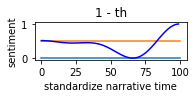

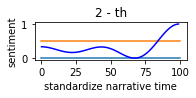

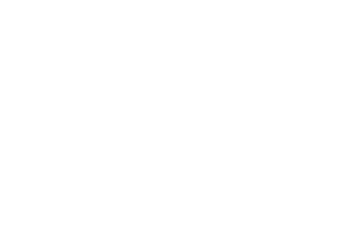

In [ ]:
# row = len(data1) // 2
row = 5
for i in range(0, 10):#10
    plt.subplot(int(row),2,int(i+1))
    plt.plot([0,100],[0,0])#画0的水平线
    plt.plot([0,100],[0.5,0.5])#画0的水平线
    plt.plot(range(len(data1[i])), data1[i],"b")
    #plt.xticks(range(0,bins+1,3))
    #plt.yticks(np.linspace(-1,1,9))
    plt.xlabel("standardize narrative time")
    plt.ylabel("sentiment")
    plt.title("%s - th"%(i+1))
    plt.show()
    plt.axis('off')

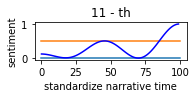

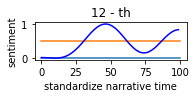

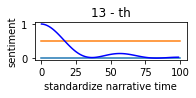

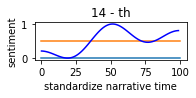

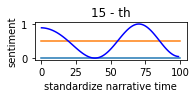

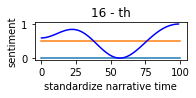

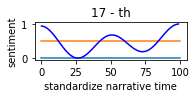

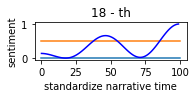

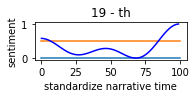

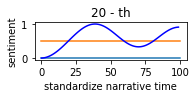

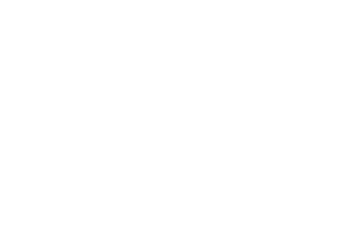

In [ ]:
for i in range(10, 20):
    plt.subplot(int(row),2,int(i+1 - 10))
    plt.plot([0,100],[0,0])#画0的水平线
    plt.plot([0,100],[0.5,0.5])#画0的水平线
    plt.plot(range(len(data1[i])), data1[i],"b")
    #plt.xticks(range(0,bins+1,3))
    #plt.yticks(np.linspace(-1,1,9))
    plt.xlabel("standardize narrative time")
    plt.ylabel("sentiment")
    plt.title("%s - th"%(i+1))
    plt.show()
    plt.axis('off')

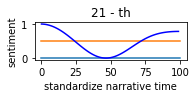

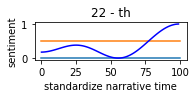

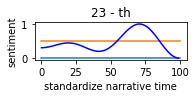

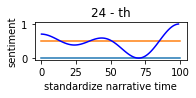

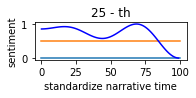

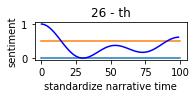

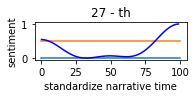

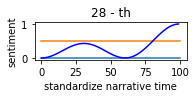

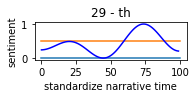

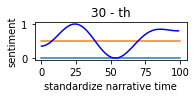

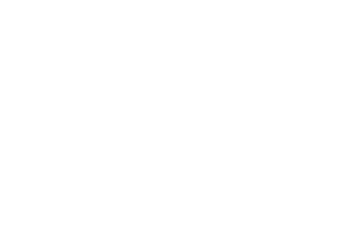

In [ ]:
for i in range(20, 30):
    plt.subplot(int(row),2,int(i+1 - 20))
    plt.plot([0,100],[0,0])#画0的水平线
    plt.plot([0,100],[0.5,0.5])#画0的水平线
    plt.plot(range(len(data1[i])), data1[i],"b")
    #plt.xticks(range(0,bins+1,3))
    #plt.yticks(np.linspace(-1,1,9))
    plt.xlabel("standardize narrative time")
    plt.ylabel("sentiment")
    plt.title("%s - th"%(i+1))
    plt.show()
    plt.axis('off')

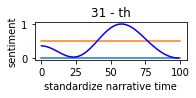

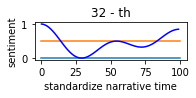

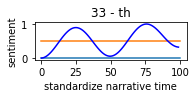

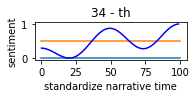

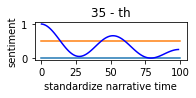

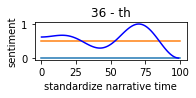

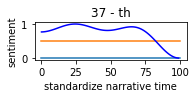

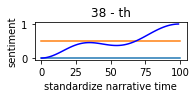

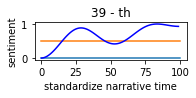

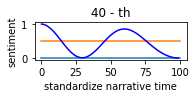

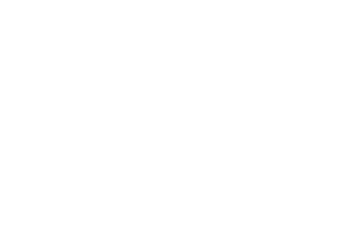

In [ ]:
for i in range(30, 40):
    plt.subplot(int(row),2,int(i+1 - 30))
    plt.plot([0,100],[0,0])#画0的水平线
    plt.plot([0,100],[0.5,0.5])#画0的水平线
    plt.plot(range(len(data1[i])), data1[i],"b")
    #plt.xticks(range(0,bins+1,3))
    #plt.yticks(np.linspace(-1,1,9))
    plt.xlabel("standardize narrative time")
    plt.ylabel("sentiment")
    plt.title("%s - th"%(i+1))
    plt.show()
    plt.axis('off')

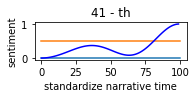

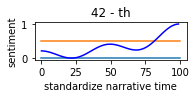

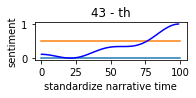

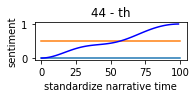

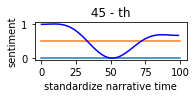

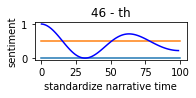

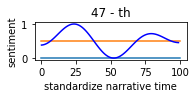

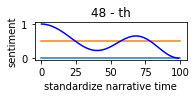

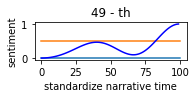

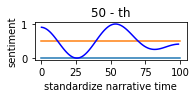

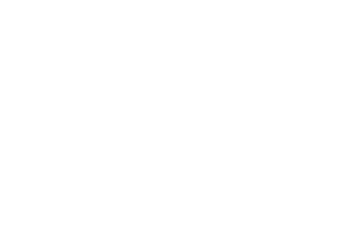

In [ ]:
for i in range(40, 50):
    plt.subplot(int(row),2,int(i+1 - 40))
    plt.plot([0,100],[0,0])#画0的水平线
    plt.plot([0,100],[0.5,0.5])#画0的水平线
    plt.plot(range(len(data1[i])), data1[i],"b")
    #plt.xticks(range(0,bins+1,3))
    #plt.yticks(np.linspace(-1,1,9))
    plt.xlabel("standardize narrative time")
    plt.ylabel("sentiment")
    plt.title("%s - th"%(i+1))
    plt.show()
    plt.axis('off')

测试用

> 可以不运行




<IPython.core.display.Javascript object>


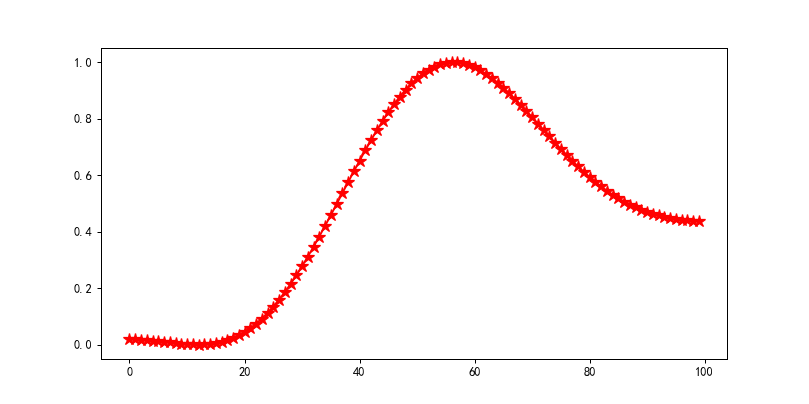

In [ ]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['figure.figsize'] = (10, 5) # 单位是inches

# ax = plt.axes()
# ax.set(facecolor = "orange")

# plt.bar(range(len(data4['score_dct'])), data4['score_dct'])
plt.plot(range(len(data1[0])), data1[0], "r", marker='*', ms=10, label="a")
# plt.hlines(0.5, xmin=0, xmax=len(tem))
# plt.xticks(range(len(df3_test['score_dct'])),df3_test['Phrase'],rotation = 90)
plt.savefig("data/picture1.png")
plt.show()